## Лабораторная работа №6 – Градиентный бустинг
Постройте бустинг для следующей задачи классификации:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data  
Примечания:  
проведите отбор признаков (Backward  selection, forward selection, permutation feature importance);  
обучите модель и подберите оптимальные гиперпараметры (ручной подбор, поиск по сетке, Optuna);  
в качестве метрик качества классификации на тестовой выборке используйте ROC_AUC, precision, recall;  
Отобразите Матрицу ошибок, PR_curve, roc_curve;  

P.S. учитывайте дисбаланс классов;  

Рекомендуемые инструменты:  
catboost.CatBoostClassifier  
lightgbm.LGBMClassifier  
sklearn.model_selection.GridSearchCV  
optuna  
sklearn.metrics  


In [1]:
import pandas as pd

df = pd.read_csv('creditcard.csv')
display(df)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


 Признак "Time" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных.  
 Признак "Amount" - это сумма транзакции, этот признак может быть использован для обучения с учетом затрат, зависящих от примера.  
 Признак "Class" является переменной отклика и принимает значение 1 в случае мошенничества и 0 в противном случае.

In [2]:
display(df['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64

Класс "Class" плохо сбалансирован, воспользуемся техникой балансировки классов

In [3]:
X = df.loc[:, df.columns[1:-1]]
Y = df.loc[:, ['Class']]

In [4]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, Y_resampled = rus.fit_resample(X, Y)

Y_resampled.describe()

,Class
count,984.000000
mean,0.500000
std,0.500254
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from catboost import CatBoostClassifier, Pool

X_train, X_val, y_train, y_val = train_test_split(X_resampled, Y_resampled, random_state=0)

model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train, use_best_model=True)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


In [ ]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return accuracy_score(y_, y_pred)

Text(0.5, 1.0, 'Feature importance')

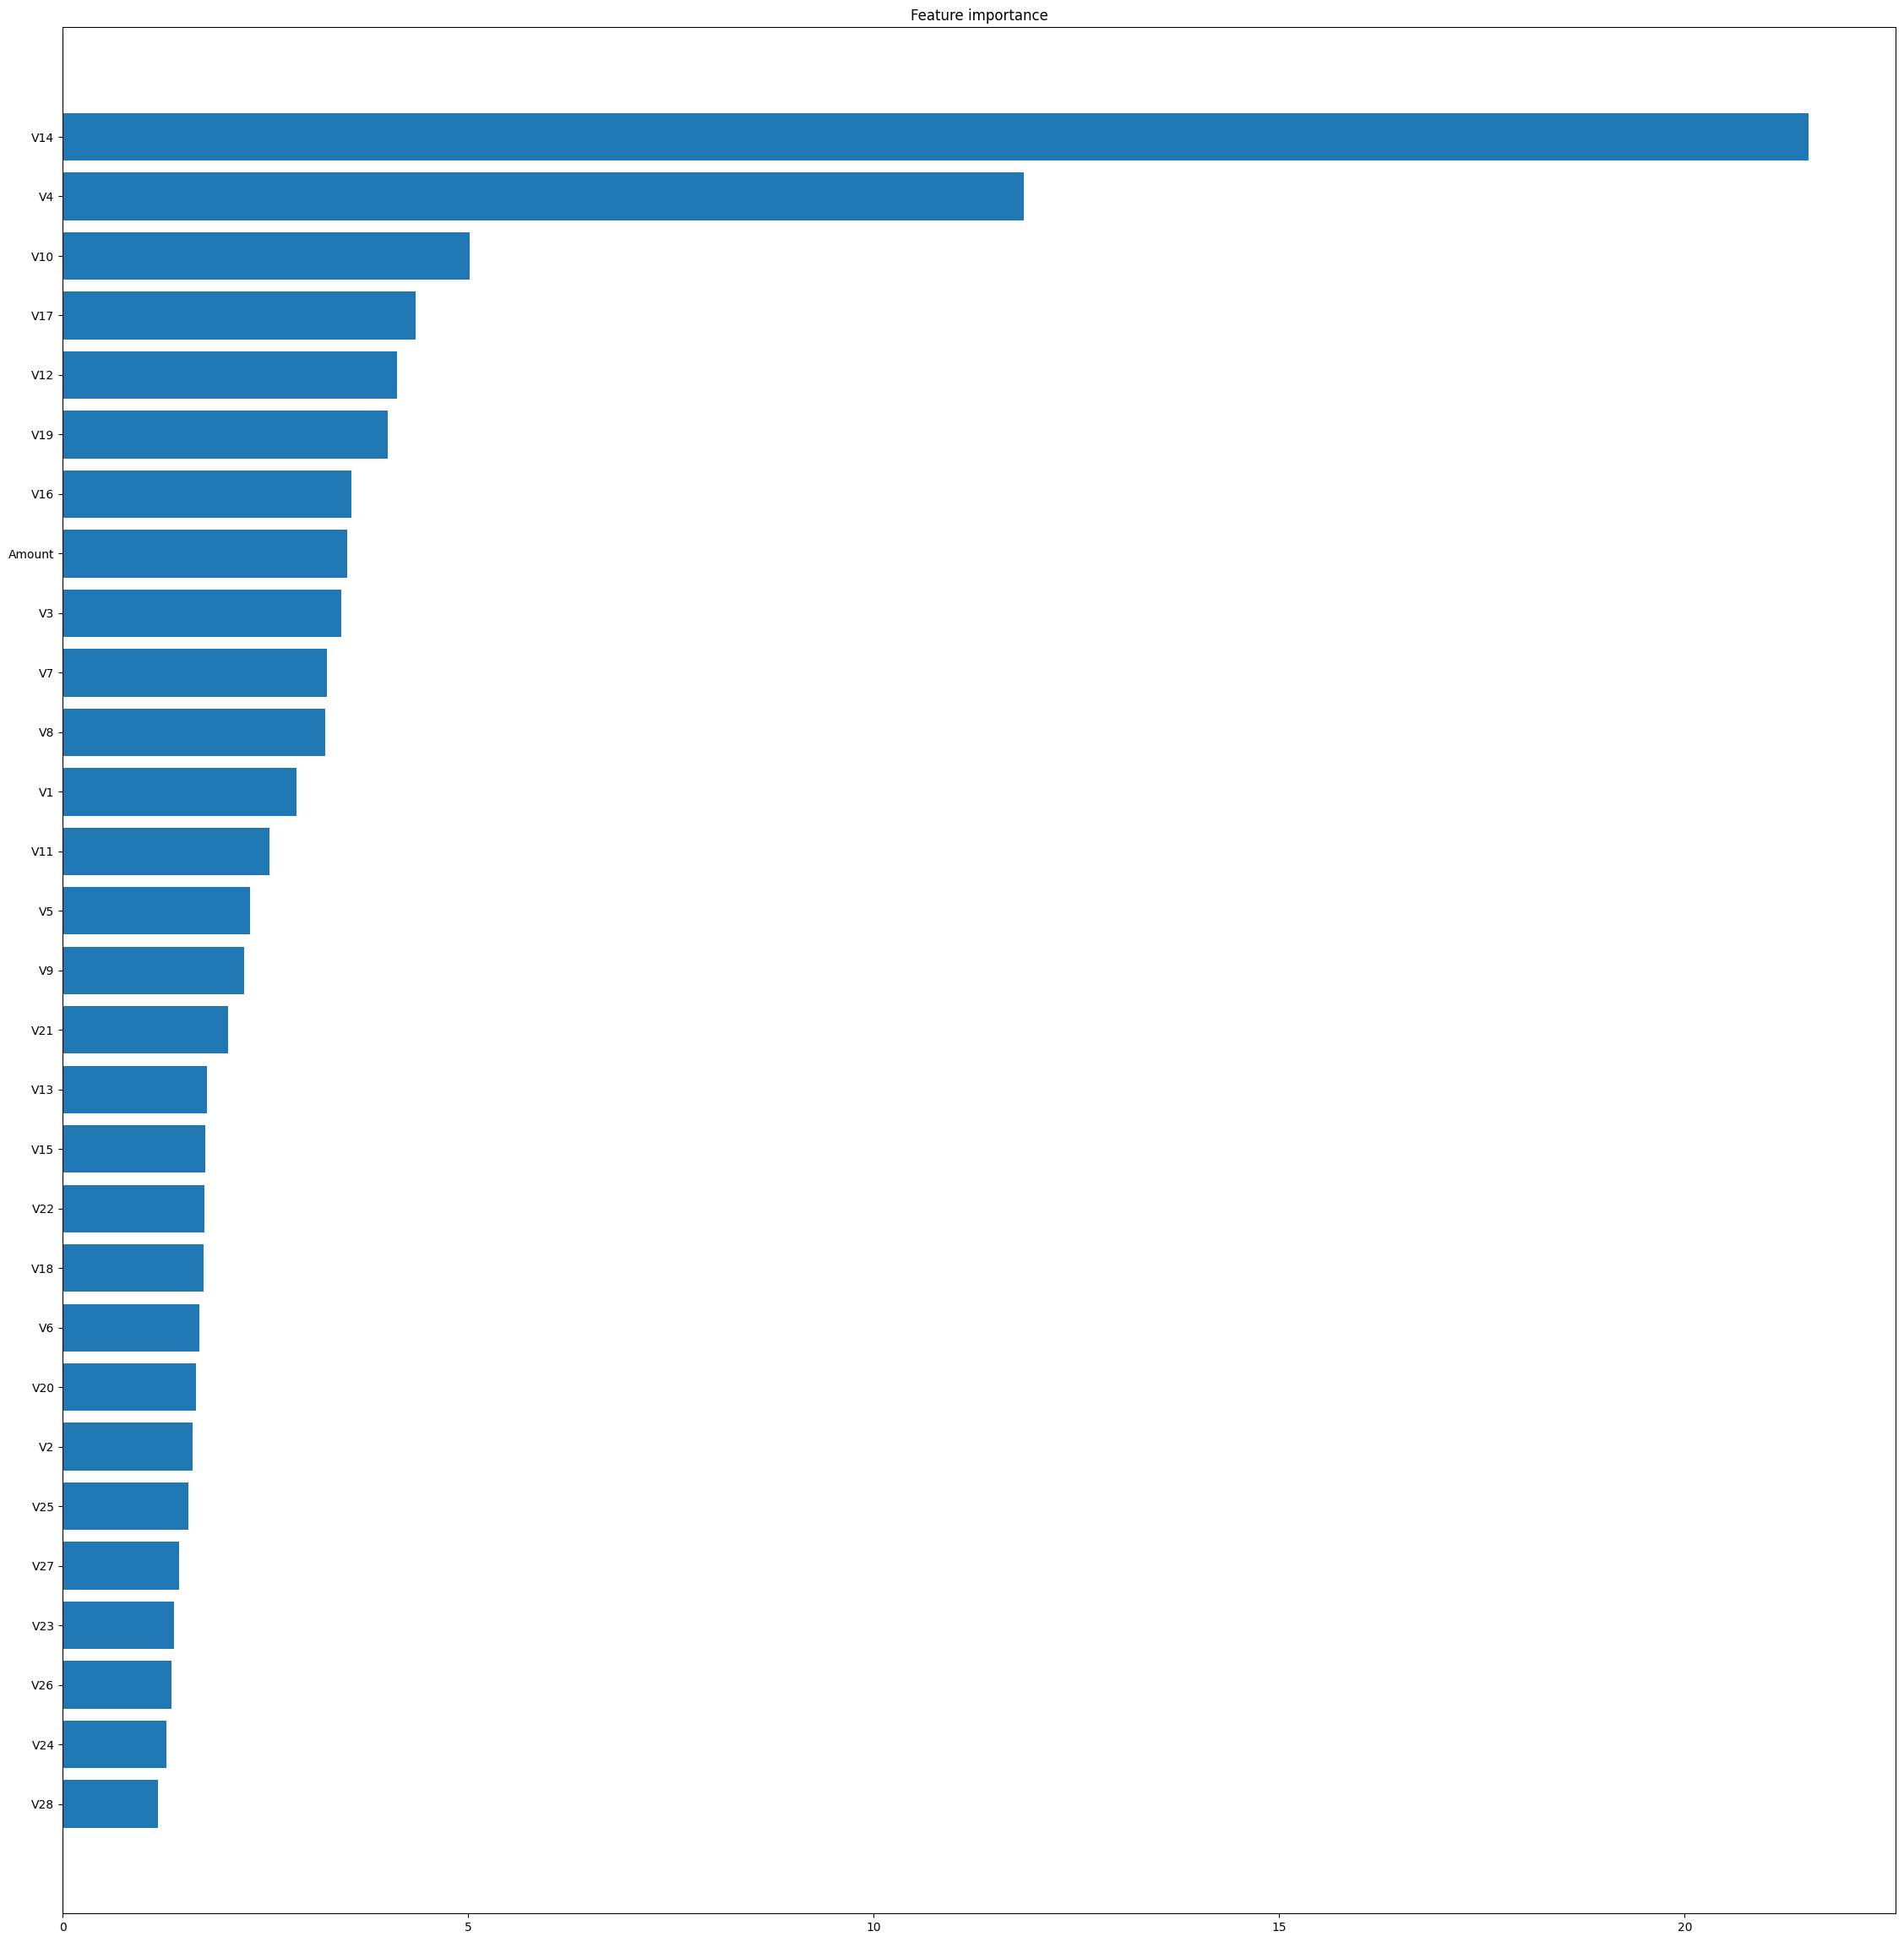

In [7]:
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
sorted_indx = np.argsort(feature_importance)

fig = plt.figure(figsize=(28, 29))

plt.barh(range(len(sorted_indx)), feature_importance[sorted_indx], align='center')
plt.yticks(range(len(sorted_indx)), X_val.columns[sorted_indx])

plt.title('Feature importance')

In [ ]:
import optuna
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

param_distrs = {'learning_rate': optuna.distributions.LogUniformDistribution(1e-4, 20),
                'min_data_in_leaf':optuna.distributions.IntUniformDistribution(1, 10),
                'iterations':optuna.distributions.IntUniformDistribution(800, 1200, 100),
                'subsample':optuna.distributions.UniformDistribution(0.7, 0.9)}

opt_search = optuna.integration.OptunaSearchCV(model, param_distrs, cv = 5,
                                                n_trials=50, scoring='f1', timeout=500)
opt_search.fit(X_train, y_train)